In [18]:
from google.colab import drive
drive.mount('/content/drive')
# 1. Import thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, GRU

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
# 2. Đọc file csv và gắng index với giá Close
df = pd.read_csv('/content/drive/MyDrive/BTC.csv')
df1=df.reset_index()['Price']
df1

0        8245.7
1        8245.1
2        8529.0
3        8403.3
4        8006.0
         ...   
1822    26920.0
1823    27183.9
1824    27035.3
1825    27403.1
1826    26828.0
Name: Price, Length: 1827, dtype: float64

In [20]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [21]:
# 4. Chia train test 6:3:1
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [22]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [23]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [24]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [25]:
# 8. Define GRU Model

model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
16/16 [==============================] - 4s 113ms/step - loss: 0.0160 - val_loss: 0.0017
Epoch 2/100
16/16 [==============================] - 1s 67ms/step - loss: 0.0014 - val_loss: 0.0026
Epoch 3/100
16/16 [==============================] - 1s 81ms/step - loss: 5.9631e-04 - val_loss: 8.8223e-04
Epoch 4/100
16/16 [==============================] - 2s 133ms/step - loss: 3.9713e-04 - val_loss: 7.9478e-04
Epoch 5/100
16/16 [==============================] - 2s 113ms/step - loss: 3.3714e-04 - val_loss: 7.5232e-04
Epoch 6/100
16/16 [==============================] - 5s 300ms/step - loss: 3.1400e-04 - val_loss: 7.4581e-04
Epoch 7/100
16/16 [==============================] - 3s 210ms/step - loss: 3.0898e-04 - val_loss: 7.2116e-04
Epoch 8/100
16/16 [==============================] - 2s 128ms/step - loss: 3.0150e-04 - val_loss: 6.9781e-04
Epoch 9/100
16/16 [==============================] - 2s 140ms/step - loss: 2.9591e-04 - val_loss: 7.1197e-04
Epoch 10/100
16/16 [=================

In [12]:
# Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

3/3 [==============================] - 0s 12ms/step


In [13]:
# Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [14]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[60:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=122
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

0 day input [0.27851668 0.27126154 0.27764731 0.30246877 0.30400067 0.30294467
 0.30617488 0.30177358 0.30834598 0.30773789 0.30864925 0.30792296
 0.31920148 0.30487938 0.30943464 0.3187738  0.31413921 0.3141952
 0.31252488 0.3064937  0.30378449 0.31140356 0.3069385  0.28870966
 0.28626017 0.28975633 0.28862101 0.28840017 0.29502389 0.32814094
 0.31588107 0.33196058 0.33286106 0.32775213 0.33609749 0.33005076
 0.3259434  0.32205066 0.31046732 0.31007229 0.31617812 0.31517344
 0.30951863 0.31747673 0.31472709 0.29744849 0.29733496 0.29859781
 0.2983132  0.295013   0.28743904 0.26645899 0.26326922 0.26810287
 0.29185589 0.32482053 0.33392328 0.32743798 0.3386574  0.37579161
 0.3683685  0.38460821 0.38090365 0.38702348 0.37376826 0.39008261
 0.37688649 0.37709489 0.38483838 0.37171691 0.37377603 0.39070004
 0.38570931 0.39261764 0.39234392 0.38833454 0.38217272 0.38780731
 0.38794884 0.38582129 0.38385703 0.38433604 0.3903299  0.41077183
 0.41961486 0.41458836 0.42238006 0.42370356 0.4210

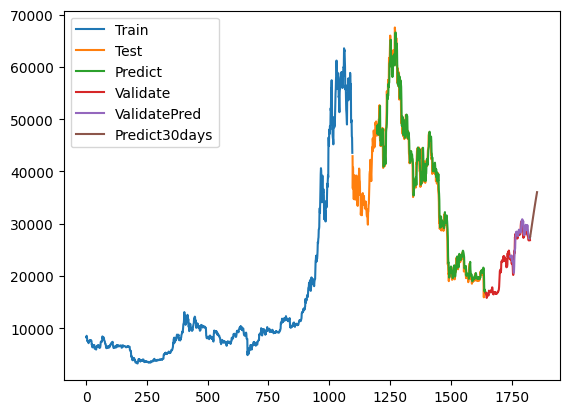

In [15]:
# 14.Vẽ hình

train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [16]:
# Respliting train test
train_size1 = int(0.7 * len(df))
test_size1 = int(0.2 * len(df))
train_data1 = df[:train_size1]
test_data1 = df[train_size1:train_size1+test_size1]
val_data1 = df[train_size1+test_size1:]
# Repredictions on the testing set
x_test1 = np.array(test_data1.drop('Price', axis=1))  # Use the features (excluding the target variable)
y_test1 = np.array(test_data1['Price'])

# Repredictions on the validation set
x_val1 = np.array(val_data1.drop('Price', axis=1))  # Use the features (excluding the target variable)
y_val1 = np.array(val_data1['Price'])

In [17]:
# Calculate evalution
#RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - y_val1)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test1)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAPE
valid_mape = np.mean(np.abs((y_val1 - y_pred_val) / y_val1)) * 100
test_mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

#MAE
valid_mae = np.mean(np.abs(y_pred_val - y_val1))
test_mae = np.mean(np.abs(y_pred - y_test1))
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

Validation RMSE: 7007.602779368188
Testing RMSE: 18573.537485190085
Validation MAPE: 29.324780098357078
Testing MAPE: 53.75965959424433
Validation MAE: 5650.310650848356
Testing MAE: 14843.685045772232
